In [2]:
import numpy as np
import pickle

# G-code generation codes are cloned from https://github.com/tibor-barsi/GcodeGenerator. Tibor Barsi is the author of the code, and was a PhD student at the Ladisk lab of the University of Ljubljana
#  We should be careful with crediting the author of the code, if we ever want to make these code public.
from src.g_code_generation_copy.gcode_generator import G_code_generator
from src.g_code_generation_copy.tool_changer_functions import save_params, load_params, printer_start, load_tool, unload_tool, tool_change, take_photo, play_sound, printer_stop
# from src.additional_functions import *
from src.network import Network_custom, replace_brackets
import os

BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"

In [3]:
def generate_parallel_lines(n, L, a, b, w, z, x_offset):
    lines = []
    spacing = (w-x_offset*2) / (n - 1)
    for i in range(n):
        offset = i * spacing + x_offset
        line = [
            [0, offset, z],  # start point
            [a * L, offset, z],  # point at a% of the line
            [b * L, offset, z],  # point at b% of the line
            [L, offset, z]  # end point
        ]
        lines.append(line)
    return lines

# Example usage
n = 21
L = 130
a = 0.25
b = 0.75
w = 34
z = .5
z_offset = .3
x_offset = 0.5

parallel_lines = generate_parallel_lines(n, L, a, b, w, z  + z_offset, x_offset)

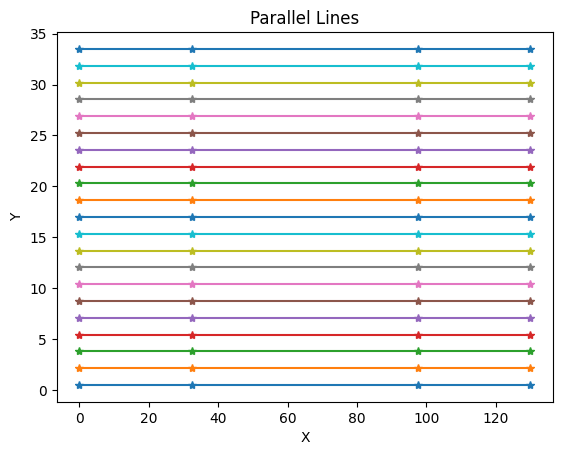

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()

for line in parallel_lines:
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    ax.plot(x_values, y_values, '-*')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Parallel Lines')
plt.show()

In [5]:
def print_parallel_line(parallel_line, ef0, ef1, comment):
    """
    Print a parallel line
    
        Parameters
        ----------
        parallel_line : list
            List of 4 points that define the parallel line
        ef0 : float
                Extrude factor for the first and last segment of the line
        ef1 : float
                Extrude factor for the middle segment of the line
        comment : str
                Comment to be added to the g-code
    """
    g_code = ''
    g_code += gen.move_to_point(parallel_line[0][0:2], parallel_line[0][2] + printing_params['nozzle_lift'], comment='Move to start point')
    g_code += gen.move_to_point(parallel_line[0][0:2], parallel_line[0][2], comment='Lower Nozzle')
    g_code += gen.unretract()
    g_code += gen._print_line(
        point0=parallel_line[0],
        point1=parallel_line[1],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef0,
        comment=comment)
    g_code += gen._print_line(
        point0=parallel_line[1],
        point1=parallel_line[2],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef1,
        comment=comment)
    g_code += gen._print_line(
        point0=parallel_line[2],
        point1=parallel_line[3],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef0,
        comment=comment)
    g_code += gen.retract()
    g_code += gen.wipe_from_last_points(g_code)    
    return g_code

In [6]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm_og.json')
start_gcode     = open(r'DATA/start_gcode.gcode', 'r').read()
end_gcode       = open(r'DATA/end_gcode.gcode', 'r').read()

temperature_settings = {'first_layer_bed_temperature': 65, 'first_layer_temperature':205, 'K-factor': 0.20}
g_code = replace_brackets(start_gcode, temperature_settings)

ef0 = printing_params['extrude_factor']*1.5
ef1 = printing_params['extrude_factor']

z_offset_top_blocks = printing_params['layer_height']/5

comment = 'Manually added lines'

bed_width = 250
bed_height = 210
n_layers_in_block = 3

gen = G_code_generator(printing_params=printing_params)

point0, point1 = [10,w+5, z_offset], [L-10,w+5, z_offset]
g_code += gen.move_to_point(point0[0:2], point0[2] + printing_params['nozzle_lift'], comment='Move to start point')
g_code += gen.move_to_point(point0[0:2], point0[2], comment='Lower Nozzle')
g_code += gen.unretract()
g_code += gen._print_line(
        point0=point0,
        point1=point1,
        move_to_start=False, # move to start point without extruding
        extrude_factor=printing_params['extrude_factor']*2,
        comment=comment)
g_code += gen.retract()
g_code += gen.wipe(np.pi) # Wipe the nozzle horizontally


g_code_new, _ =gen.print_cuboid([[0,0],[L*.2, w]],z_start = z_offset, height = printing_params['layer_height']*n_layers_in_block, extrude_factor=printing_params['extrude_factor'])
for key, value in g_code_new.items():
    g_code += value
g_code_new, _=gen.print_cuboid([[L*.8, 0],[L, w]],z_start = z_offset, height = printing_params['layer_height']*n_layers_in_block, extrude_factor=printing_params['extrude_factor'])
for key, value in g_code_new.items():
    g_code += value
for parallel_line in parallel_lines:
    g_code += print_parallel_line(parallel_line, ef0=ef0, ef1=ef1, comment=comment)

g_code_new, _=gen.print_cuboid([[0,0],[L*.2, w]],z_start = printing_params['layer_height']*n_layers_in_block + z_offset + z_offset_top_blocks, height = printing_params['layer_height']*n_layers_in_block, extrude_factor=printing_params['extrude_factor'])
for key, value in g_code_new.items():
    g_code += value
g_code_new, _=gen.print_cuboid([[L*.8, 0],[L, w]],z_start = printing_params['layer_height']*n_layers_in_block + z_offset + z_offset_top_blocks, height = printing_params['layer_height']*n_layers_in_block, extrude_factor=printing_params['extrude_factor'])
for key, value in g_code_new.items():
    g_code += value

g_code += end_gcode


# model_name = 'Pull_samples'
model_name = 'Pull_samples_lower_top_blocks'
with open(os.path.join(BYU_UW_root, 'GCODE', model_name + '.gcode'), "w") as g_code_file:
    g_code_file.write(g_code)
print('G-code generated')

G-code generated


# Pull samples matching Calebs samples

In [16]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm_og.json')
start_gcode     = open(r'DATA/start_gcode.gcode', 'r').read()
end_gcode       = open(r'DATA/end_gcode.gcode', 'r').read()

temperature_settings = {'first_layer_bed_temperature': 65, 'first_layer_temperature':205, 'K-factor': 0.20}
g_code = replace_brackets(start_gcode, temperature_settings)

g_code += "\n \n ;The the cross sectional area of the pull sample is 12 passes * 0.078294515mm^2  = 0.93953418 mm^2\n \n"

L, W = 150, 5
rectangle = [[0,0], [L, W]]
ef = printing_params['extrude_factor']

# Victoria asked me to add a small additional offset. I think you shouldn't need this if the printing bed is properly calibrated, please set it to zero if you don't need it.
additional_offset = printing_params['layer_height']/5
z_offset = printing_params['layer_height'] + additional_offset

# Initialize the G-code generator
gen = G_code_generator(printing_params=printing_params)

# Add a purge line:
point0, point1 = [10,W+5, z_offset], [L-10,W+5, z_offset]
g_code += gen.move_to_point(point0[0:2], point0[2] + printing_params['nozzle_lift'], comment='Move to start point')
g_code += gen.move_to_point(point0[0:2], point0[2], comment='Lower Nozzle')
g_code += gen.unretract()
g_code += gen._print_line(
        point0=point0,
        point1=point1,
        move_to_start=False, # move to start point without extruding
        extrude_factor=printing_params['extrude_factor']*2,
        comment=comment)
g_code += gen.retract()
g_code += gen.wipe(np.pi) # Wipe the nozzle horizontally

# Print the pull sample
# g_code += gen.print_surface(surface=rectangle, infill_angle=0, overlap_factor=0.25, z=printing_params['layer_height'] + additional_offset, extrude_factor=ef, comment= '')
g_code += gen.print_surface(surface=rectangle, infill_angle=0, overlap_factor=0., z=printing_params['layer_height'] + additional_offset, extrude_factor=ef, comment= '')

# model_name = 'Pull_samples'
model_name = 'Pull_samples_BYU'
with open(os.path.join(BYU_UW_root, 'GCODE', model_name + '.gcode'), "w") as g_code_file:
    g_code_file.write(g_code)
print('G-code generated')

G-code generated
